# Bitcoin USD - Time Series Forecasting

# <font color='blue'>0. Identification for Business Requirements</font> <a class="anchor" id="first-bullet"></a>

### A Short Description About the Dataset & It's Source


####  Dataset of Bitcoin Historical Data
The dataset is a mix of CSV files for select bitcoin exchanges for the time period of Jan 2012 to December March 2021, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price. 

Source of Datasets:

Created by Zielak,
Neuroscience Ph.D. - Data Scientist <br>
https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

## <font color= blue >1. Importing the Necessary Libraries</font> <a class="anchor" id="second-bullet"></a>

In [48]:
import tensorflow as tf

In [49]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [50]:
#########BASIC
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

######## GRAPHICAL
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc
import matplotlib.pyplot as plt

######## STATISTICAL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import matplotlib.pyplot as plt

######### RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

######## FB PROPHET
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

########ARIMAX
import pmdarima as pm

######### WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [51]:
from cryptocmd import CmcScraper

## <font color= blue >2. Loading the dataset </font> <a class="anchor" id="third-bullet"></a>

In [52]:
# Block 1
# load data with CmC Scrapper
class CryptoData:
    """
    This class is responsible for fetching and formatting cryptocurrency data.
    
    Input:
        crypto_symbol (str): The symbol of the cryptocurrency, e.g., "BTC" for Bitcoin.
        
    Methods:
        get_cryptocmd_data: Fetches cryptocurrency data and returns a formatted DataFrame.
        get_display_data: Fetches and formats cryptocurrency data for display purposes.
    """
    def __init__(self, crypto_symbol: str):
        self.crypto_symbol = crypto_symbol

    def _fetch_cryptocmd_data(self) -> pd.DataFrame:
        try:
            scraper = CmcScraper(self.crypto_symbol)
            return scraper.get_dataframe()
        except Exception as e:
            print(f'An error occurred while fetching data: {e}')
            return pd.DataFrame()  # Return an empty DataFrame when an error occurs

    def get_cryptocmd_data(self) -> pd.DataFrame:
        df = self._fetch_cryptocmd_data()
        df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
        return df.round(2)

    @staticmethod
    def _format_monetary_value(value: float) -> str:
        return "${:,.2f}".format(value)

    @staticmethod
    def _format_volume_value(value: float) -> str:
        return "{:,.2f}".format(value)

    def get_display_data(self) -> pd.DataFrame:
        display_df = self.get_cryptocmd_data().copy()
        monetary_columns = ['Open', 'High', 'Low', 'Close', 'Market Cap']
        display_df[monetary_columns] = display_df[monetary_columns].applymap(self._format_monetary_value)
        display_df['Volume'] = display_df['Volume'].apply(self._format_volume_value)
        return display_df

# -------------------------------------------------------------------------------------

## <font color= blue >3. Exploratory Data Analysis </font> <a class="anchor" id="fourth-bullet"></a>

#### Data Exploration

In this section we will explore the Historic Bitcoin Prices and try to find some insights. We will be using the Coinbase dataset as it is one of the mostly used Bitcoin Exchange/Wallet in the world.

In [53]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3699 entries, 2023-06-13 to 2013-04-28
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        3699 non-null   float64
 1   High        3699 non-null   float64
 2   Low         3699 non-null   float64
 3   Close       3699 non-null   float64
 4   Volume      3699 non-null   float64
 5   Market Cap  3699 non-null   float64
dtypes: float64(6)
memory usage: 202.3 KB


In [55]:
data.describe()

,Open,High,Low,Close,Volume,Market Cap
count,3699.000000,3699.000000,3699.000000,3699.000000,3.699000e+03,3.699000e+03
mean,11696.259973,11983.796088,11379.636175,11702.022736,1.430764e+10,2.171024e+11
std,15542.631015,15932.258681,15097.066122,15540.158858,1.906682e+10,2.942832e+11
min,68.500000,74.560000,65.530000,68.430000,0.000000e+00,7.784112e+08
25%,538.960000,572.790000,521.810000,546.490000,4.788520e+07,7.144724e+09
50%,6239.250000,6374.980000,6103.330000,6242.190000,5.002962e+09,1.083385e+11
75%,16688.380000,16938.980000,16499.665000,16704.665000,2.501136e+10,3.191867e+11
max,67549.740000,68789.630000,66382.060000,67566.830000,3.509679e+11,1.274831e+12


In [56]:
display(data.head(5))
display(data.tail(5))

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2023-06-13,25902.94,26376.35,25728.37,25918.73,1.414347e+10,5.028638e+11
2023-06-12,25934.29,26087.92,25675.20,25902.50,1.167789e+10,5.025237e+11
2023-06-11,25854.03,26203.44,25668.99,25940.17,1.073261e+10,5.032310e+11
2023-06-10,26481.76,26531.05,25501.84,25851.24,1.987293e+10,5.014774e+11
2023-06-09,26505.92,26770.29,26339.32,26480.38,1.101555e+10,5.136570e+11


,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-05-02,116.38,125.60,92.28,105.21,0.0,1.168517e+09
2013-05-01,139.00,139.89,107.72,116.99,0.0,1.298955e+09
2013-04-30,144.00,146.93,134.05,139.00,0.0,1.542813e+09
2013-04-29,134.44,147.49,134.00,144.54,0.0,1.603769e+09
2013-04-28,135.30,135.98,132.10,134.21,0.0,1.488567e+09


#### Missing Values

In this section we will explore any Missing Values present in the dataframe.

In [57]:
# Number of NaNs on each columns 
data.isna().sum()

Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

In [58]:
# Function to check wheter or not a particular datasets has missing values
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns


missing_values_table(data)

Your selected dataframe has 6 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [59]:
missing_values_table(data)

Your selected dataframe has 6 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [60]:
# Displaying all Dates with missing values information

nan_rows  = data[data.isna().any(axis=1)]
nan_rows.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,


__Interpolation__
Unfortunately, time series, or at least the ones that are worthy of interest, are usually non-stationary. This means that their statistical characteristics — average, variance, and standard deviation — do change with time.

In [61]:
missing_values_table(data)

Your selected dataframe has 6 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


#### Downsampling Data - decreasing the timestamp frequency

Here we decided to downsample the data into days, months, quarters and years for visualization and further analysis.


In [62]:
# Default resampling is set to per Hour. 
# Here we decided to downsample the data into days, months, quarters and years for visualization and further analysis.
df = data.copy()

# Resampling to daily frequency
df_day = df.resample('D').mean()

# Resampling to monthly frequency
df_week = df.resample('W').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to quarterly frequency
df_quarter = df.resample('Q-DEC').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

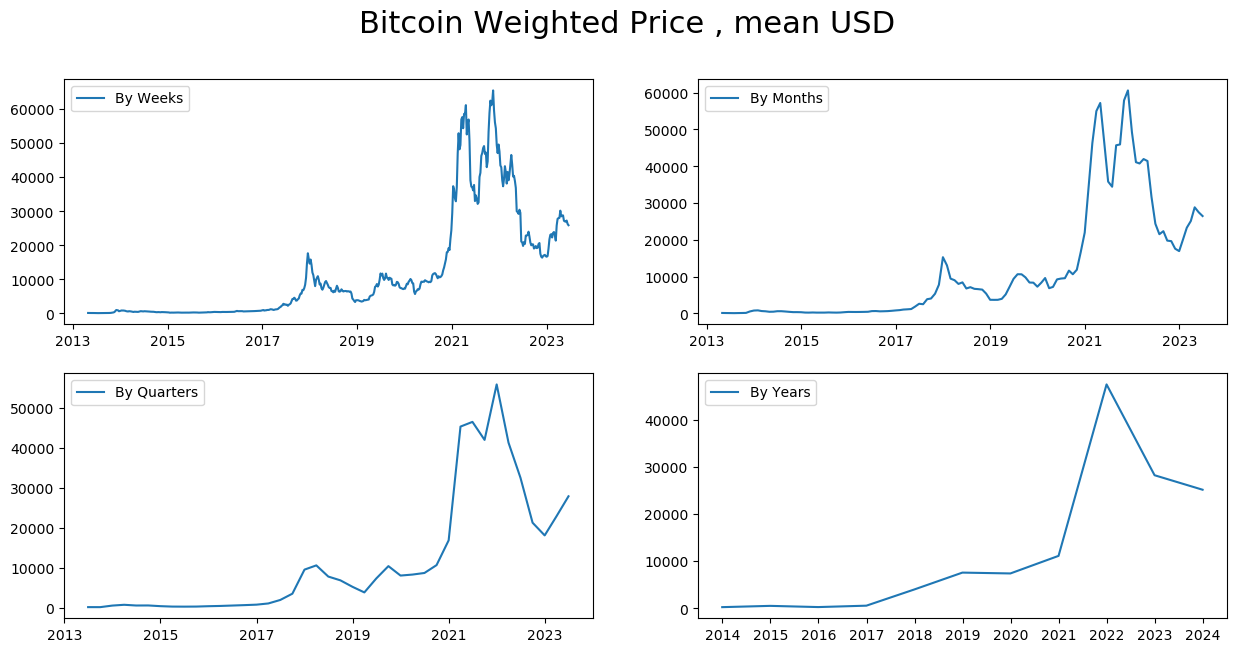

In [63]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin Weighted Price , mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df_week.Close, '-', label='By Weeks')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_quarter.Close, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Close, '-', label='By Years')
plt.legend()

plt.show()

# -------------------------------------------------------------------------------------

## <font color= blue >4. Data Visualization </font> <a class="anchor" id="fourth-bullet"></a>

In [64]:
# basically creating a range that includes all data
start = '2013-06-01'
end = '2023-06-01'

# find rows between start and end time 
data_monthly = df_month[(df_month.index >= start) & (df_month.index <= end)].reset_index()
data_monthly.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2013-06-30,108.856667,111.300667,104.602000,107.761333,0.0,1.216792e+09
1,2013-07-31,90.311290,93.869032,86.719677,90.512258,0.0,1.034233e+09
2,2013-08-31,113.041935,116.002258,111.387742,113.905161,0.0,1.317466e+09
3,2013-09-30,130.180667,134.164333,127.375333,130.061667,0.0,1.522703e+09
4,2013-10-31,156.031613,161.944194,151.148065,158.311935,0.0,1.877944e+09


### Visualize Bitcoin Prices from 2012-2021

In [65]:
# We use Plotly to create the plots https://plot.ly/python/
trace1 = go.Scatter(
    x = data_monthly['Date'],
    y = data_monthly['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = data_monthly['Date'],
    y = data_monthly['High'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = data_monthly['Date'],
    y = data_monthly['Close'].astype(float),
    mode = 'lines',
    name = 'Weighted Avg'
)

layout = dict(
    title='Historical Bitcoin Prices (2012-2018) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([

                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

_ = [trace1,trace2, trace3]
fig = dict(data=_, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

### Visualizing Bitcoin Market Volume from 2012-2021

In [66]:
trace1 = go.Scatter(
    x = data_monthly['Date'],
    y = data_monthly['Volume'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Bitcoin Volume (USD) (2012-2021) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

_= [trace1]
fig = dict(data=_, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

# -------------------------------------------------------------------------------------

#### Selecting the range for our analysis: 2012 -- 2021

There are an incredible amount of challenges in correctly forecasting a time-series analysis for Crypto.
Too many factors drive the price volatility (that historical data in unable to capture). Due to this we decided to range our dataset to exclude the year of 2021 forward, removing the steep upward trend in price

In [67]:
# basically creating a range that includes all data
start = '2013-06-01'
end = '2023-06-01'

# find rows between start and end time 
df_day = df_day[(df_day.index >= start) & (df_day.index <= end)]
df_week = df_week[(df_week.index >= start) & (df_week.index <= end)]
df_month = df_month[(df_month.index >= start) & (df_month.index <= end)]
df_quarter = df_quarter[(df_quarter.index >= start) & (df_quarter.index <= end)]
df_year = df_year[(df_year.index >= start) & (df_year.index <= end)]

# -------------------------------------------------------------------------------------

## <font color= blue >5. Checking stationary vs Non-stationary Data </font> <a class="anchor" id="fifth-bullet"></a>

### ACF and PACF

In [68]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import matplotlib.pyplot as plt

Text(0.5,1,'PACF for Weighted Price -- Daily')

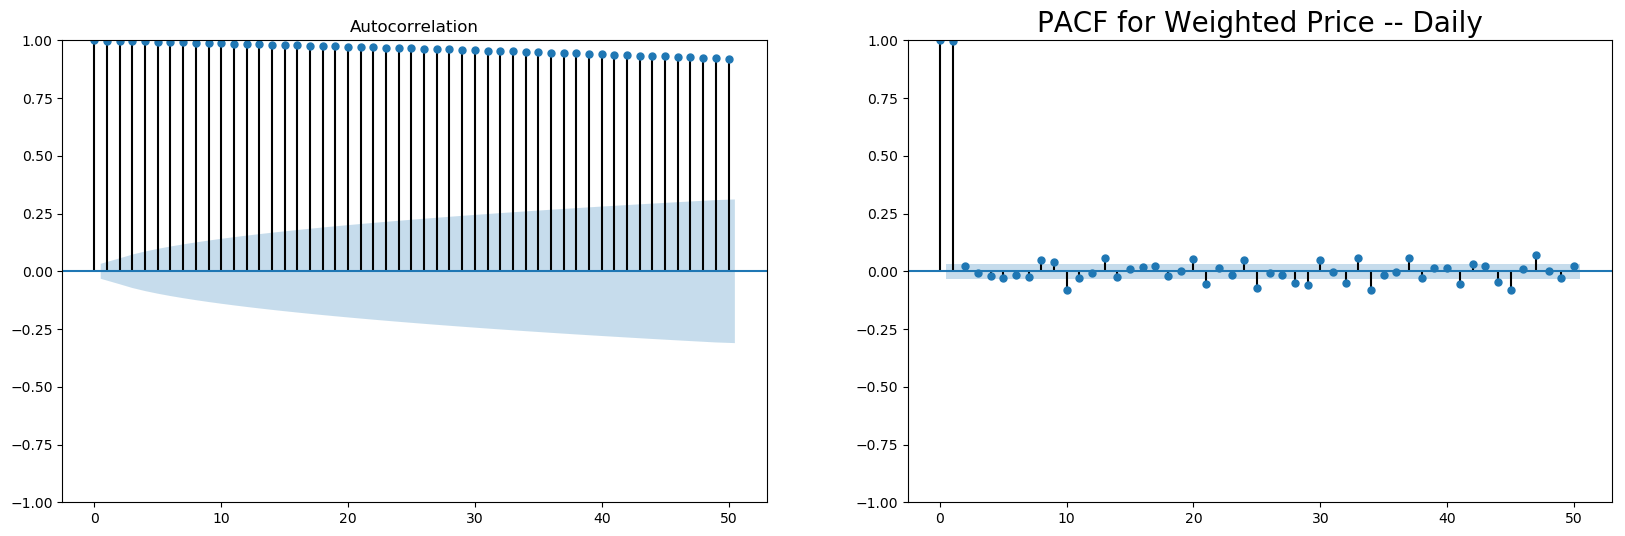

In [69]:
# For daily Frequency ACF and PACF

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

plot_acf(df_day.Close, lags=50, alpha=0.05, ax=ax1)
plt.title("ACF for Weighted Price", size=20)

plot_pacf(df_day.Close, lags=50, alpha=0.05, method='ols', ax=ax2)
plt.title("PACF for Weighted Price -- Daily", size=20)

Figure 1 - presents the time series, ACF and PACF plots for the usd prices of the Bitcoin. <br>

### ACF and PACF

Trough visual inspection Figure 1 it is clear that the data values do not have a constant mean and variances.We can observe decaying pattern in ACF plot and the highly significant first lag in PACF. <br>

Autocorrelations are declining gradually as the number of lags such a property is common in nonstationary processes. <br> 

### ADF Augmented Dickey–Fuller test

The formal statistical tool for checking stationarity of time series data is to go for Augumented Dickey Fuller (ADF) test.

__H0: The time series is non-stationary.__<br>
__HA: The time series is stationary.__

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [70]:
## Augmented Dickey–Fuller test

    # "HO: Non-stationary"
    # "H1: Stationary"

from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
series = df_day.Close
X = series.values

In [71]:
# Stability Test (Dickey-Fuller Test)
def is_stationary(y):
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [72]:
is_stationary(X)

Result: Non-Stationary (H0: non-stationary, p-value: 0.489)


In [73]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.590135
p-value: 0.488547
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


#### Time Series Components

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

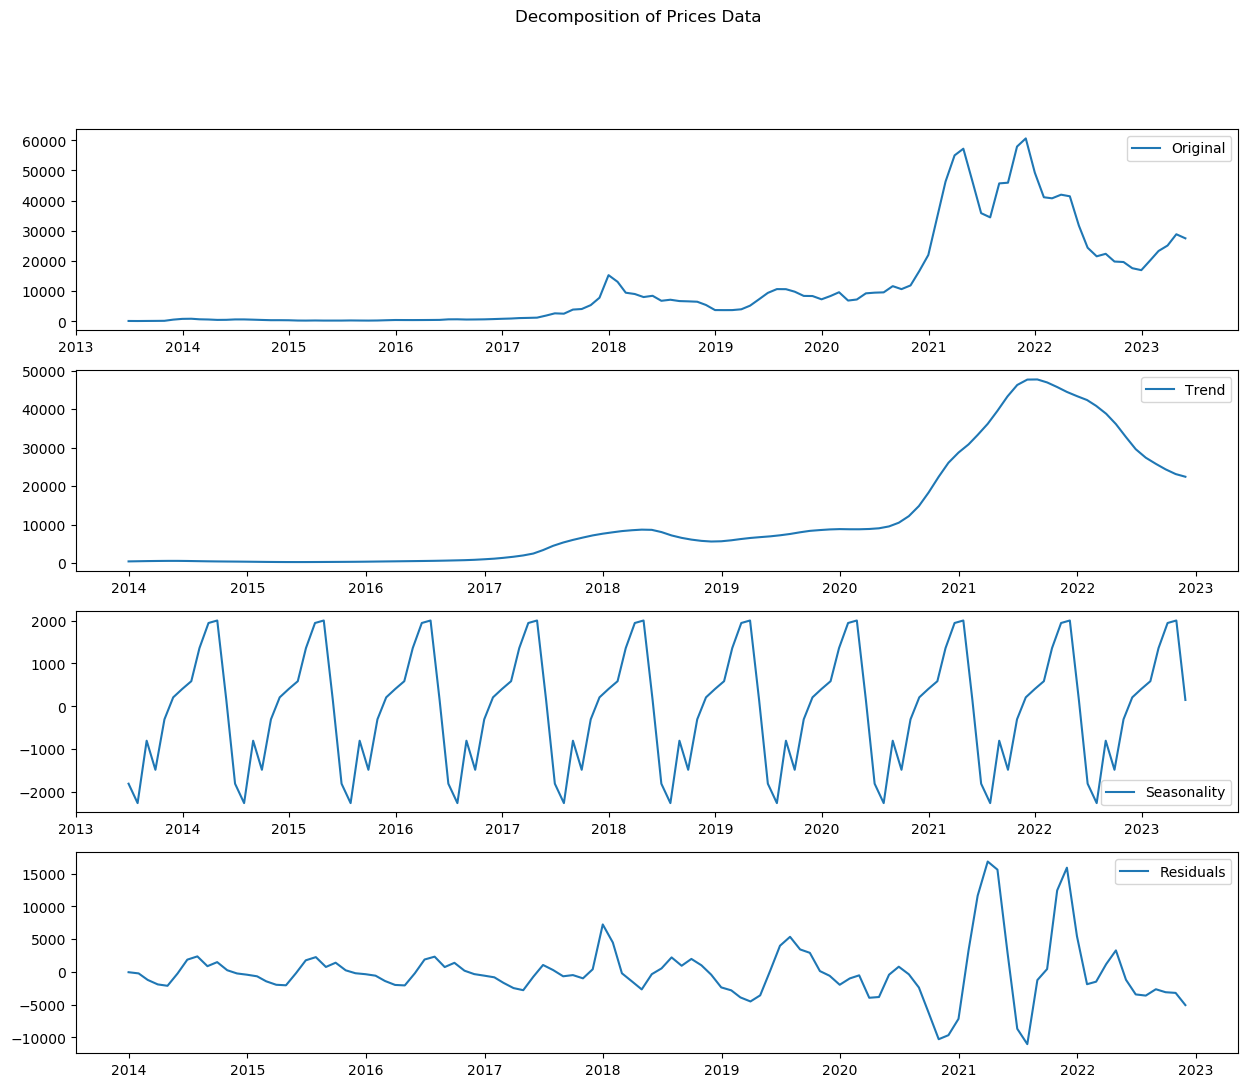

In [75]:
decomposition = sm.tsa.seasonal_decompose(df_month.Close)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(15,12))

plt.subplot(411)
plt.plot(df_month.Close, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

Post time series decomposition we don't observe any seasonality. Also, there is no constant mean, variance and covariance, hence the series is Non Stationary. 

# -------------------------------------------------------------------------------------

## <font color= blue >6. Normalizing Time Series Data </font> <a class="anchor" id="fifth-bullet"></a>

In [125]:
df_day = df_day[[col for col in df_day.columns if col != 'Close'] + ['Close']]
df_day

,Open,High,Low,Volume,Market Cap,Close
Date,,,,,,
2013-06-01,128.82,129.78,127.20,0.000000e+00,1.451916e+09,129.30
2013-06-02,129.30,129.40,115.05,0.000000e+00,1.373837e+09,122.29
2013-06-03,122.50,122.50,116.00,0.000000e+00,1.373708e+09,122.22
2013-06-04,120.74,123.84,119.10,0.000000e+00,1.365338e+09,121.42
2013-06-05,121.40,123.47,119.90,0.000000e+00,1.368486e+09,121.65
...,...,...,...,...,...,...
2023-05-28,26871.16,28193.45,26802.75,1.454523e+10,5.444836e+11,28085.65
2023-05-29,28075.59,28432.04,27563.88,1.518131e+10,5.379249e+11,27745.88
2023-05-30,27745.12,28044.76,27588.50,1.325108e+10,5.371065e+11,27702.35


In [126]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the original DataFrame
data_normalized = df_day.copy()
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']

# Instantiate the StandardScaler
scaler = StandardScaler()
data_normalized[columns_to_scale] = scaler.fit_transform(data_normalized[columns_to_scale])
data_normalized

,Open,High,Low,Volume,Market Cap,Close
Date,,,,,,
2013-06-01,-0.746490,-0.746289,-0.747591,-0.754760,-0.734859,-0.746959
2013-06-02,-0.746459,-0.746313,-0.748394,-0.754760,-0.735124,-0.747409
2013-06-03,-0.746896,-0.746745,-0.748331,-0.754760,-0.735124,-0.747414
2013-06-04,-0.747009,-0.746661,-0.748126,-0.754760,-0.735153,-0.747465
2013-06-05,-0.746966,-0.746684,-0.748073,-0.754760,-0.735142,-0.747451
...,...,...,...,...,...,...
2023-05-28,0.970531,1.011396,1.015809,0.005504,1.106750,1.048273
2023-05-29,1.047863,1.026340,1.066124,0.038751,1.084507,1.026455
2023-05-30,1.026645,1.002084,1.067752,-0.062140,1.081732,1.023659


In [127]:
# Define the percentage for the testing data
test_percentage = 0.2

# Calculate the index position to split the data
split_index = int(len(data_normalized) * (1 - test_percentage))

# Split the data into train and test sets
data_train = data_normalized.iloc[:split_index]
data_test = data_normalized.iloc[split_index:]

X_train, y_train = data_train.iloc[:, :-1], data_train.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1], data_test.iloc[:, -1]

In [128]:
y_train= y_train.to_numpy()
y_test= y_test.to_numpy()
X_train= X_train.to_numpy()
X_test= X_test.to_numpy()

In [129]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2922, 5) (2922,) (731, 5) (731,)


In [130]:
# reshaping to  3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2922, 1, 5) (2922,) (731, 1, 5) (731,)


In [131]:
test = pd.DataFrame(data_test['Close'])
train = pd.DataFrame(data_train['Close'])
pd.concat([train, test], join='outer')

,Close
Date,
2013-06-01,-0.746959
2013-06-02,-0.747409
2013-06-03,-0.747414
2013-06-04,-0.747465
2013-06-05,-0.747451
...,...
2023-05-28,1.048273
2023-05-29,1.026455
2023-05-30,1.023659


In [132]:
test=test.rename(columns={'Close': 'Test Set'})
train=train.rename(columns={'Close': 'Train Set'}) 
whole_data=train.join(test, how='outer' )
whole_data.head()

,Train Set,Test Set
Date,,
2013-06-01,-0.746959,NaN
2013-06-02,-0.747409,NaN
2013-06-03,-0.747414,NaN
2013-06-04,-0.747465,NaN
2013-06-05,-0.747451,NaN


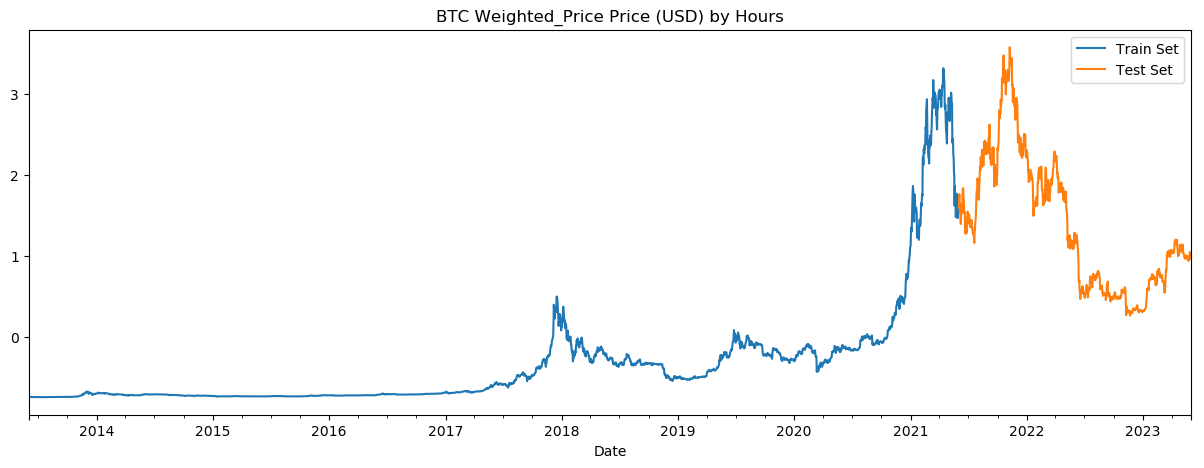

In [133]:
plotting = whole_data.plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

# -------------------------------------------------------------------------------------

In [168]:
data

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2023-06-13,25902.94,26376.35,25728.37,25918.73,1.414347e+10,5.028638e+11
2023-06-12,25934.29,26087.92,25675.20,25902.50,1.167789e+10,5.025237e+11
2023-06-11,25854.03,26203.44,25668.99,25940.17,1.073261e+10,5.032310e+11
2023-06-10,26481.76,26531.05,25501.84,25851.24,1.987293e+10,5.014774e+11
2023-06-09,26505.92,26770.29,26339.32,26480.38,1.101555e+10,5.136570e+11
...,...,...,...,...,...,...
2013-05-02,116.38,125.60,92.28,105.21,0.000000e+00,1.168517e+09
2013-05-01,139.00,139.89,107.72,116.99,0.000000e+00,1.298955e+09
2013-04-30,144.00,146.93,134.05,139.00,0.000000e+00,1.542813e+09


## <font color= blue >7. Model Construction </font> <a class="anchor" id="fifth-bullet"></a>

## <font color= blue >7.1 Multivariate Time Series Forecasting with LSTM </font> <a class="anchor" id="fifth-bullet"></a>

In [135]:
model = Sequential()
model.add(LSTM(128,activation="tanh",return_sequences=True, input_shape=(1, 5)))
model.add(Dropout(0.2))
model.add(LSTM(128,activation="tanh", return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, activation="tanh",return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256, activation="tanh",return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2,validation_data=(X_test, y_test), shuffle=False)

Epoch 1/100
59/59 - 13s - loss: 0.3981 - val_loss: 1.9178 - 13s/epoch - 218ms/step
Epoch 2/100
59/59 - 2s - loss: 0.1672 - val_loss: 0.7271 - 2s/epoch - 33ms/step
Epoch 3/100
59/59 - 2s - loss: 0.4639 - val_loss: 3.0505 - 2s/epoch - 32ms/step
Epoch 4/100
59/59 - 2s - loss: 0.3296 - val_loss: 1.9901 - 2s/epoch - 34ms/step
Epoch 5/100
59/59 - 2s - loss: 0.0764 - val_loss: 0.2291 - 2s/epoch - 31ms/step
Epoch 6/100
59/59 - 2s - loss: 0.0995 - val_loss: 0.1615 - 2s/epoch - 32ms/step
Epoch 7/100
59/59 - 2s - loss: 0.2482 - val_loss: 1.4628 - 2s/epoch - 31ms/step
Epoch 8/100
59/59 - 2s - loss: 0.0665 - val_loss: 0.2091 - 2s/epoch - 31ms/step
Epoch 9/100
59/59 - 2s - loss: 0.0536 - val_loss: 0.1224 - 2s/epoch - 31ms/step
Epoch 10/100
59/59 - 2s - loss: 0.0832 - val_loss: 0.2702 - 2s/epoch - 33ms/step
Epoch 11/100
59/59 - 2s - loss: 0.0631 - val_loss: 0.1239 - 2s/epoch - 32ms/step
Epoch 12/100
59/59 - 2s - loss: 0.1144 - val_loss: 0.4510 - 2s/epoch - 34ms/step
Epoch 13/100
59/59 - 2s - loss: 0.

In [159]:
model = Sequential()
model.add(LSTM(120,activation="sigmoid",input_shape=(1,5)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2,validation_data=(X_test, y_test), shuffle=False)

Epoch 1/100
59/59 - 3s - loss: 0.4922 - val_loss: 1.8553 - 3s/epoch - 56ms/step
Epoch 2/100
59/59 - 1s - loss: 0.2551 - val_loss: 1.0092 - 1s/epoch - 24ms/step
Epoch 3/100
59/59 - 1s - loss: 0.1242 - val_loss: 0.5051 - 1s/epoch - 24ms/step
Epoch 4/100
59/59 - 1s - loss: 0.0831 - val_loss: 0.2671 - 1s/epoch - 24ms/step
Epoch 5/100
59/59 - 1s - loss: 0.0661 - val_loss: 0.1636 - 1s/epoch - 24ms/step
Epoch 6/100
59/59 - 1s - loss: 0.0656 - val_loss: 0.1108 - 1s/epoch - 24ms/step
Epoch 7/100
59/59 - 1s - loss: 0.0595 - val_loss: 0.0961 - 1s/epoch - 23ms/step
Epoch 8/100
59/59 - 1s - loss: 0.0603 - val_loss: 0.0904 - 1s/epoch - 24ms/step
Epoch 9/100
59/59 - 2s - loss: 0.0581 - val_loss: 0.0770 - 2s/epoch - 26ms/step
Epoch 10/100
59/59 - 1s - loss: 0.0548 - val_loss: 0.0665 - 1s/epoch - 25ms/step
Epoch 11/100
59/59 - 2s - loss: 0.0511 - val_loss: 0.0544 - 2s/epoch - 26ms/step
Epoch 12/100
59/59 - 1s - loss: 0.0486 - val_loss: 0.0508 - 1s/epoch - 24ms/step
Epoch 13/100
59/59 - 1s - loss: 0.048

In [160]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 120)               60480     
                                                                 
 dropout_13 (Dropout)        (None, 120)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 121       
                                                                 
Total params: 60,601
Trainable params: 60,601
Non-trainable params: 0
_________________________________________________________________


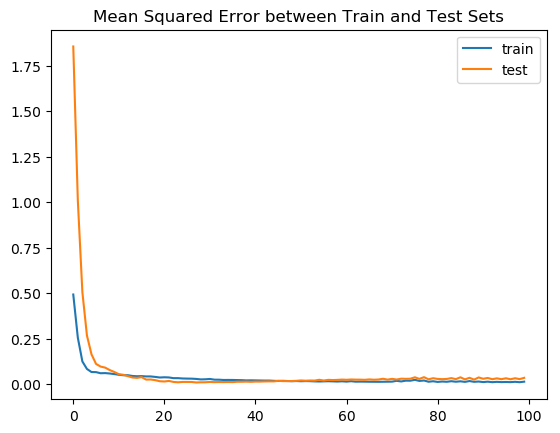

In [161]:
# plot history
import matplotlib.pyplot as pyplot 
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Mean Squared Error between Train and Test Sets')
pyplot.show()

In [162]:
predictions = model.predict(X_test)
predictions.shape

23/23 [==============================] - 0s 6ms/step


(731, 1)

In [163]:
predictions_reshaped = predictions.reshape(predictions.shape[0], -1)
predictions_reshaped.shape

(731, 1)

In [164]:
# 2. Convert both the predictions and actual values (y_test) to a DataFrame
predictions_df = pd.DataFrame(predictions_reshaped, columns=['Predicted'])
actual_values_df = pd.DataFrame(y_test, columns=['Actual'])

In [165]:
# Reset index of both DataFrames if they have non-integer index
predictions_df.reset_index(drop=True, inplace=True)
actual_values_df.reset_index(drop=True, inplace=True)

# 3. Merge the DataFrames based on the index
comparison_df = pd.concat([actual_values_df, predictions_df], axis=1)

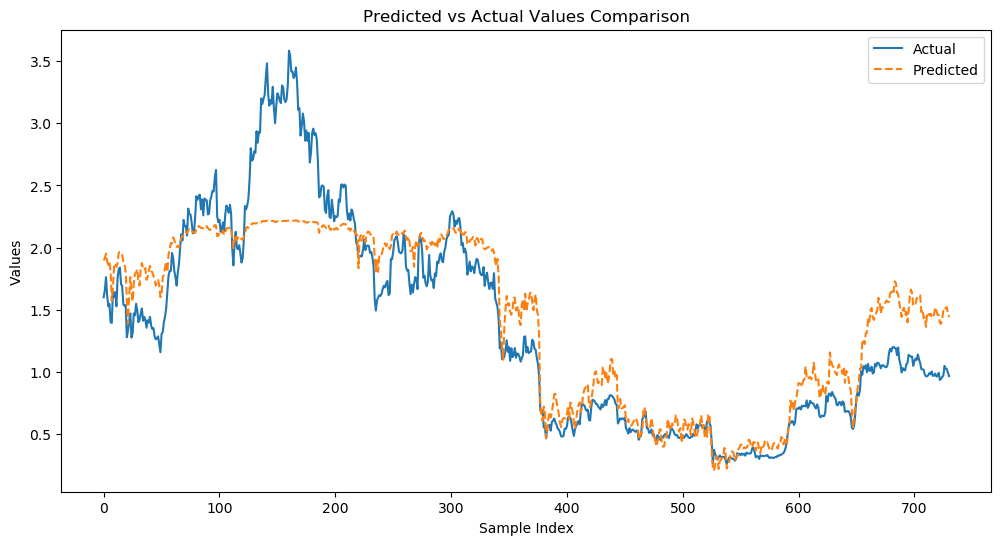

In [154]:
# 4. Create a line plot to visualize the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Actual'], label='Actual')
plt.plot(comparison_df['Predicted'], label='Predicted', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.title('Predicted vs Actual Values Comparison')
plt.show()

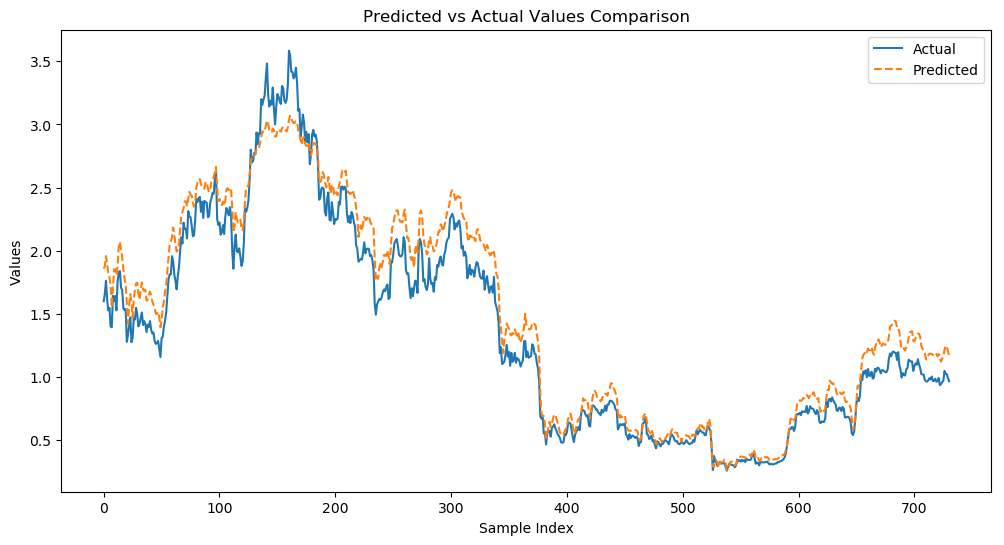

In [166]:
# 4. Create a line plot to visualize the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Actual'], label='Actual')
plt.plot(comparison_df['Predicted'], label='Predicted', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.title('Predicted vs Actual Values Comparison')
plt.show()

In [156]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values_df, predictions_df)
mse = mean_squared_error(actual_values_df, predictions_df)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values_df, predictions_df)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² score: {r2}")


Mean Absolute Error (MAE): 0.2571218151125103
Mean Squared Error (MSE): 0.1241060871635844
Root Mean Squared Error (RMSE): 0.35228693867866345
R² score: 0.8181988854565672


In [167]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values_df, predictions_df)
mse = mean_squared_error(actual_values_df, predictions_df)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values_df, predictions_df)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² score: {r2}")


Mean Absolute Error (MAE): 0.15733874179372156
Mean Squared Error (MSE): 0.03413608001793282
Root Mean Squared Error (RMSE): 0.18475951942439345
R² score: 0.9499945769362312


In [138]:
# Predict BTC price using the trained model
predicted_BTC_price = model.predict(X_test)
print("Shape of predicted_BTC_price:", predicted_BTC_price.shape)

23/23 [==============================] - 3s 15ms/step
Shape of predicted_BTC_price: (731, 1, 1)


In [139]:
# Concatenate predicted_BTC_price and X_test
from numpy import concatenate
Bitcoin_pred = concatenate((predicted_BTC_price[:, :, 0], X_test), axis=1)
print("Shape of Bitcoin_pred:", Bitcoin_pred.shape)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [119]:
predicted_BTC_price = model.predict(X_test)
predicted_BTC_price.shape

23/23 [==============================] - 7s 16ms/step


(731, 1, 1)

In [120]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
print("Shape of X_test: ", X_test.shape)

Shape of X_test:  (731, 5)


In [121]:
from numpy import concatenate

Bitcoin_pred = concatenate((predicted_BTC_price, X_test[:,:]), axis=1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
Bitcoin_pred = scaler.inverse_transform(Bitcoin_pred)
Bitcoin_pred = Bitcoin_pred[:,0]
Bitcoin_pred

In [ ]:
data_test=pd.DataFrame(scaler.inverse_transform(data_test), columns=data.columns, index=test.index)
data_test.head()

In [ ]:
data_train=pd.DataFrame(scaler.inverse_transform(data_train), columns=data.columns, index=train.index)
data_train.head()

In [ ]:
data_test['M_LSTM_Pred'] = Bitcoin_pred
mixed_data = pd.concat([data_test, data_train], sort=False)
mixed_data.head()

In [ ]:
#saving the predicted values in a common data frame for future comparison
final_data = mixed_data
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'M_LSTM_Pred': 'LSTM prediction'})
final_data = final_data[['Timestamp','Weighted_Price','LSTM prediction']]

In [ ]:
final_data

In [ ]:
mixed_data[['Weighted_Price','M_LSTM_Pred']].plot(figsize=(15, 5),title=('Weighted Price vs Weighted Price M_LSTM'))

In [ ]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 
from sklearn.metrics import mean_absolute_error

In [ ]:
rmse=math.sqrt(mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['M_LSTM_Pred']))
print('RMSE:',rmse)

In [ ]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['M_LSTM_Pred'])

In [ ]:
r2_score(data_test['Weighted_Price'], data_test['M_LSTM_Pred'])

# -------------------------------------------------------------------------------------

## <font color= blue >7.2 Univariate Time Series with LSTM </font> <a class="anchor" id="fifth-bullet"></a>

Preparing the data to train and validate the the Univariate Time Series Model

In [ ]:
only_train=train.to_numpy()
only_test=test.to_numpy()

In [ ]:
only_train1=only_train[0:len(only_train)-1]
only_test1=only_test[0:len(only_test)-1]

only_y_train=only_train[1:len(only_train)]
only_y_test=only_test[1:len(only_test)]

In [ ]:
len(only_train1)

In [ ]:
print(only_train1.shape, only_y_train.shape, only_test1.shape, only_y_test.shape)

In [ ]:
len(only_train[1:len(only_train)])

In [ ]:
only_train1 = only_train1.reshape((only_train1.shape[0], 1, only_train1.shape[1]))
only_test1 = only_test1.reshape((only_test1.shape[0], 1, only_test1.shape[1]))
print(only_train1.shape, only_y_train.shape, only_test1.shape, only_y_test.shape)

In [ ]:
only_train.shape

In [ ]:
only_y_train=only_y_train.reshape((only_y_train.shape[0],only_y_train.shape[1]))

In [ ]:
only_y_test = only_y_test.reshape((only_y_test.shape[0], only_y_test.shape[1]))

In [ ]:
print(only_train1.shape, only_y_train.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


uni_model = Sequential()
uni_model.add(LSTM(120,activation="sigmoid",input_shape=(1,1)))
uni_model.add(Dropout(0.2))
uni_model.add(Dense(1))
uni_model.compile(loss='mean_squared_error', optimizer='adam')  
history1=uni_model.fit(only_train1, only_y_train, epochs=100, batch_size=50, verbose=2, validation_data=(only_test1, only_y_test), shuffle=False)#

In [ ]:
import matplotlib.pyplot as pyplot 
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Mean Squared Error between Train and Test Sets')
pyplot.show()

In [ ]:
uni_predicted_BTC_price = uni_model.predict(only_test.reshape(only_test.shape[0],1,1))
uni_predicted_BTC_price

In [ ]:
X_test.shape

In [ ]:
data_test['M_LSTM_Pred'] = Bitcoin_pred
mixed_data = pd.concat([data_test, data_train], sort=False)

In [ ]:
Bitcoin_pred_uni = concatenate((uni_predicted_BTC_price, X_test), axis=1)
Bitcoin_pred_uni = scaler.inverse_transform(Bitcoin_pred_uni)
Bitcoin_pred_uni[:,0]

In [ ]:
data_test['Uni_LSTM_Pred']=Bitcoin_pred_uni[:,0]
data_test.head()

In [ ]:
mixed_data2 = pd.concat([data_test, data_train], sort=False)
mixed_data2.head()

In [ ]:
mixed_data2[['Weighted_Price','Uni_LSTM_Pred']].plot(figsize=(15, 5),title=('Actual Weighted Price vs Weighted Price U_LSTM'))

In [ ]:
mixed_data2=mixed_data2.reset_index()

In [ ]:
final_data['Uni_LSTM_Pred']=mixed_data2['Uni_LSTM_Pred']
final_data

In [ ]:
rmse=math.sqrt(mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Uni_LSTM_Pred']))
print('RMSE:',rmse)

In [ ]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Uni_LSTM_Pred'])

In [ ]:
r2_score(data_test['Weighted_Price'], data_test['Uni_LSTM_Pred'])

# -------------------------------------------------------------------------------------

## <font color= blue >7.3 Time Series Forecasting with FacebookProphet </font> <a class="anchor" id="fifth-bullet"></a>

__Prophet__ is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. <br>

It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. <br>


__Data does not need to be normalized, Prophet will actually internally scale y before fitting the model__<br>

In [ ]:
# In anaconda prompt
# conda install libpython m2w64-toolchain -c msys2
# pip install pystan
# pip install fbprophet

In [ ]:
df_day.head()

In [ ]:
#Facebook Prophet packages:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric


from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
# Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Renaming the column names accroding to Prophet's requirements
prophet_df = df_day.reset_index()[['Timestamp','Weighted_Price']]
prophet_df.rename(columns={'Timestamp':'ds','Weighted_Price':'y'},inplace=True)

In [ ]:
# Basic model 
prophet_basic = Prophet()
prophet_basic.fit(prophet_df[['ds','y']])

In [ ]:
# Making predictions for 1 year, until 2022-01-01
future= prophet_basic.make_future_dataframe(periods=365)#Making predictions for one year
future.tail(1)

In [ ]:
forecast = prophet_basic.predict(future)

In [ ]:
fig = prophet_basic.plot(forecast)

__Adding ChangePoints to Prophet__<br>
Changepoints are the datetime points where the time series have abrupt changes in the trajectory.<br>
By default, Prophet adds 25 changepoints to the initial 80% of the data-set.

In [ ]:
fig_1 = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig_1.gca(), prophet_basic, forecast)

print('Change points: ','{prophet_basic.changepoints}\n')

In [ ]:
print('Change points:\n\n',prophet_basic.changepoints)

__Adding Multiple Regressors__ <br>
Additional regressors can be added to the Prophet model. This is done by using add_regressor. <br>
Additional regressor column value needs to be present in both the fitting as well as prediction dataframes.


In [ ]:
prophet_df['Open'] = df_day.reset_index()['Open']
prophet_df['High'] = df_day.reset_index()['High']
prophet_df['Low'] = df_day.reset_index()['Low']
prophet_df['Vol(BTC)'] = df_day.reset_index()['Volume_(BTC)']
prophet_df['Vol(curr)'] = df_day.reset_index()['Volume_(Currency)']

In [ ]:
prophet_df.head()

In [ ]:
pro_regressor= Prophet()
pro_regressor.add_regressor('Open')
pro_regressor.add_regressor('High')
pro_regressor.add_regressor('Low')
pro_regressor.add_regressor('Vol(BTC)')
pro_regressor.add_regressor('Vol(curr)')

splitter= '2019-01-01'
train_X = prophet_df.loc[prophet_df.ds <= splitter]
test_X = prophet_df.loc[prophet_df.ds > splitter]

In [ ]:
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=365)

In [ ]:
#Forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);

In [ ]:
df_cv = cross_validation(pro_regressor, initial='100 days', period='180 days', horizon = '365 days')
pm = performance_metrics(df_cv, rolling_window=0.1)
display(pm.head(),pm.tail())

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test_X.ds, test_X.y, color='r')
fig = pro_regressor.plot(forecast_data, ax=ax)

In [ ]:
 from prophet.utilities import regressor_coefficients

In [ ]:
regressor_coefficients(pro_regressor)

In [ ]:
#for comparision of predictions
forecast_data = forecast_data.rename(columns={'ds': 'Timestamp'})
forecast_data = forecast_data.rename(columns={'yhat': 'prophet'})
test_X = test_X.rename(columns={'ds': 'Timestamp'})
test_X = test_X.rename(columns={'y': 'Weighted_Price'})

data_compare = pd.merge(test_X, forecast_data, on='Timestamp')
data_compare = data_compare[['Timestamp','Weighted_Price','prophet']]
data_compare = data_compare.set_index('Timestamp')
data_compare.head()

In [ ]:
data_compare.tail()

In [ ]:
rmse=math.sqrt(mean_squared_error(y_true=data_compare['Weighted_Price'],
                   y_pred=data_compare['prophet']))
print('RMSE:',rmse)

In [ ]:
mean_absolute_error(y_true=data_compare['Weighted_Price'],
                   y_pred=data_compare['prophet'])

In [ ]:
r2_score(data_compare['Weighted_Price'], data_compare['prophet'])

# -------------------------------------------------------------------------------------

## <font color= blue >7.4 Time Series Forecasting with ARIMAX </font> <a class="anchor" id="fifth-bullet"></a>

__pmdarima package: project description__ https://pypi.org/project/pmdarima/#description

For this model we will be using Auto ARIMA functionality in python using the pmdarima package. <br>

In Auto ARIMA function itself operates a bit like a grid search. The model itself will generate the optimal p, d, and q parameters which would be best suitable for the data set to provide better forecasting.

In [ ]:
import pmdarima as pm

In [ ]:
df_1 = df_day.copy()

In [ ]:
# basically creating a range that includes all data
start = '2012-01-01'
end = '2021-01-01'

# find rows between start and end time 
df_1 = df_1[(df_1.index >= start) & (df_1.index <= end)]
df_1.tail()

In [ ]:
df_1.info()

In [ ]:
exogenous_features = ['Open','High','Low','Close','Volume_(BTC)','Volume_(Currency)']

In [ ]:
model = pm.auto_arima(data_train.Weighted_Price, exogenous=data_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(data_train.Weighted_Price, exogenous=data_train[exogenous_features])

forecast = model.predict(n_periods=len(data_test), exogenous=data_test[exogenous_features])
data_test["ARIMAX_Pred"] = forecast

In [ ]:
model.summary()

In [ ]:
mixed_data3 = pd.concat([data_test, data_train], sort=False)
mixed_data3.head()

In [ ]:
mixed_data3[['Weighted_Price','ARIMAX_Pred']].plot(figsize=(15, 5),title=('Actual Weighted Price vs ARIMAX Price Prediction'))

In [ ]:
# For Monthly Frequency ACF and PACF

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

data_test[["Weighted_Price"]].plot(figsize=(14, 7), ax=ax1)

data_test[["ARIMAX_Pred"]].plot(figsize=(14, 7), ax=ax2)
plt.title("Weighted Price vs Arimax Prediction", size=20)


In [ ]:
rmse=math.sqrt(mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['ARIMAX_Pred']))
print('RMSE:',rmse)

In [ ]:

mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['ARIMAX_Pred'])

In [ ]:
r2_score(data_test['Weighted_Price'], data_test['ARIMAX_Pred'])

# -------------------------------------------------------------------------------------

## <font color= blue >8. Results comparison </font> <a class="anchor" id="fifth-bullet"></a>

In [ ]:
mixed_data3['Prophet_Pred'] = data_compare['prophet']
final_comp = mixed_data3.copy()
display(final_comp.head())

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.Weighted_Price, name='Weighted_Price',
                         line=dict(color='chartreuse', width=4)))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.M_LSTM_Pred, name = 'M_LSTM_Pred',
                         line=dict(color='coral', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.Uni_LSTM_Pred, name='Uni_LSTM_Pred',
                         line=dict(color='crimson', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.ARIMAX_Pred, name='ARIMAX_Pred',
                         line = dict(color='cyan', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.Prophet_Pred, name='Prophet_Pred',
                         line=dict(color='darkblue', width=4, dash='dot')))
fig.update_layout(title='Models Comparison',
                   xaxis_title='Years',
                   yaxis_title='USD (thousands)')
fig.show()

In [ ]:
# split data into train and test sets
splitter= '2019-01-01'
df_results = final_comp[['Weighted_Price','M_LSTM_Pred','Uni_LSTM_Pred','ARIMAX_Pred','Prophet_Pred']]
df_results = df_results.loc[df_results.index > splitter]

display(df_results.head())


# Plot 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.Weighted_Price, name='Weighted_Price',
                         line=dict(color='chartreuse', width=4)))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.M_LSTM_Pred, name = 'M_LSTM_Pred',
                         line=dict(color='coral', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.Uni_LSTM_Pred, name='Uni_LSTM_Pred',
                         line=dict(color='crimson', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.ARIMAX_Pred, name='ARIMAX_Pred',
                         line = dict(color='yellow', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.Prophet_Pred, name='Prophet_Pred',
                         line=dict(color='darkblue', width=4, dash='dot')))
fig.update_layout(title='Models Comparison',
                   xaxis_title='Years',
                   yaxis_title='USD (thousands)')
fig.show()

In [ ]:
# PLOTS
fig = plt.figure(figsize=[35, 15])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df_results.Weighted_Price, '-', label='Real')
plt.legend()
plt.subplot(221)
plt.plot(df_results.M_LSTM_Pred, '-', label='M_LSTM_Pred')
plt.legend()
plt.subplot(221)
plt.plot(df_results.Uni_LSTM_Pred, '-', label='UNI_LSTM')
plt.legend()
plt.subplot(221)
plt.plot(df_results.ARIMAX_Pred, '-', label='Arimax')
plt.legend()
plt.subplot(221)
plt.plot(df_results.Prophet_Pred, '-', label='Prophet')
plt.legend()
plt.show()

In [ ]:
df_results

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['M_LSTM_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['M_LSTM_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['M_LSTM_Pred']))

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Uni_LSTM_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Uni_LSTM_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['Uni_LSTM_Pred']))

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['ARIMAX_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['ARIMAX_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['ARIMAX_Pred']))

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Prophet_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Prophet_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['Prophet_Pred']))